## Topic Modeling with Bag-of-Words Model & LDA
### 1. Corpus Creation

In [24]:
# retrieve variables from File 'Preprocessing'
%store -r data_lemmatized df

import gensim

# Create Dictionary
id2word = gensim.corpora.Dictionary(data_lemmatized)

# Filtering out tokens appearing in less than 20 documents or more than 70% of documents
id2word.filter_extremes(no_below=20, no_above=0.7)

# Convert each document in data_lemmatized to a string
corpus_strings = [' '.join(doc) for doc in data_lemmatized]

# Create Bag of Words Corpus
bow_corpus = [id2word.doc2bow(doc) for doc in data_lemmatized]
bow_corpus[10]

# View Corpus
[[(id2word[id], freq) for id, freq in cp] for cp in bow_corpus[0:1]]

[[('age', 1),
  ('always', 1),
  ('attraction', 1),
  ('character', 1),
  ('definitely', 1),
  ('different', 1),
  ('dream', 1),
  ('enter', 1),
  ('especially', 1),
  ('feeling', 1),
  ('forever', 1),
  ('kid', 1),
  ('money', 1),
  ('park', 1),
  ('place', 1),
  ('priceless', 1),
  ('regret', 1),
  ('see', 1),
  ('special', 1),
  ('spend', 1),
  ('trip', 1),
  ('young', 1)]]

### 2. Default LDA model
#### Default model

In [25]:
# calculate lda model with default parameters & 10 topics
num_topics = 10
lda_model_bow = gensim.models.LdaMulticore(bow_corpus, 
                                             id2word=id2word, 
                                             num_topics=num_topics, 
                                             workers=3)

#### Default Topics

In [26]:
# show initial topics with top 10 assigned words
lda_model_bow.show_topics(10, num_words=10, formatted=False)

[(0,
  [('park', 0.03146447),
   ('ride', 0.029221995),
   ('day', 0.023201475),
   ('time', 0.018261269),
   ('disneyland', 0.017739836),
   ('visit', 0.015566044),
   ('disney', 0.01117674),
   ('year', 0.010817203),
   ('go', 0.009970024),
   ('see', 0.0087839905)]),
 (1,
  [('great', 0.020914627),
   ('time', 0.02051215),
   ('park', 0.0198296),
   ('ride', 0.01979211),
   ('disneyland', 0.018505372),
   ('day', 0.017700678),
   ('place', 0.014007202),
   ('visit', 0.011155726),
   ('really', 0.010260344),
   ('disney', 0.010058737)]),
 (2,
  [('park', 0.026716027),
   ('ride', 0.025025068),
   ('time', 0.018733127),
   ('disney', 0.015279499),
   ('great', 0.0132268565),
   ('go', 0.012798925),
   ('disneyland', 0.0119285),
   ('well', 0.011894641),
   ('get', 0.009633389),
   ('day', 0.009547381)]),
 (3,
  [('ride', 0.02906265),
   ('park', 0.026023634),
   ('get', 0.017614737),
   ('day', 0.017216217),
   ('time', 0.016103625),
   ('disneyland', 0.015550848),
   ('kid', 0.013698

#### Default coherence score

In [27]:
from gensim.models import CoherenceModel

# Compute Coherence Score with default alpha and beta values
coherence_model_lda_bow = CoherenceModel(model=lda_model_bow, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda_bow = coherence_model_lda_bow.get_coherence()
print('Coherence Score: ', coherence_lda_bow)

Coherence Score:  0.3306174955820095


### 3. Compute model performance metrics

#### Calculation of Coherence Score with varying parameters

In [28]:
# Define function for calculation of coherence values
def compute_coherence_values_bow(corpus, dictionary, model):
    coherence_model_lda_bow = CoherenceModel(model=model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda_bow.get_coherence()

# Define function for training the model with different parameters
def train_lda_model(params, corpus, id2word):
    a, b, k = params
    lda_model_bow = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k, alpha=a, eta=b)
    cv = compute_coherence_values_bow(corpus=corpus, dictionary=id2word, model=lda_model_bow)
    return cv

In [30]:
import pandas as pd

# create lists with varying values for alpha and beta
alpha_list = ['symmetric', 'asymmetric', 0.01, 0.31, 0.61, 0.91]
beta_list = ['symmetric', 0.01, 0.31, 0.61, 0.91]

# create 
num_of_docs = len(bow_corpus)
corpus_sets = [gensim.utils.ClippedCorpus(bow_corpus, int(num_of_docs * 0.75)), bow_corpus]
corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [], 'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}

def run_train_lda_model(corpus, id2word, corpus_title):
    # loop through number of topics
    for k in range(2, 11):
        for a in alpha_list:
            for b in beta_list:
                params = (a, b, k)
                cv = train_lda_model(params, corpus=corpus, id2word=id2word)
                
                model_results['Validation_Set'].append(corpus_title)
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)

# iterate through validation corpuses
for i, corpus in enumerate(corpus_sets):
    run_train_lda_model(corpus, id2word, corpus_title[i])

# create data frame with results
df_results = pd.DataFrame(model_results)
df_results.to_csv('lda_tuning_results_bow.csv', index=False)

#### Influence of the number of topics on the coherence score

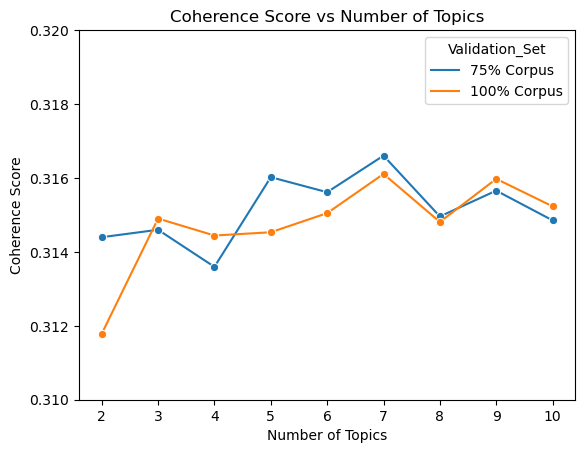

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Read the model_results from the CSV file
model_results_bow = pd.read_csv('lda_tuning_results_bow.csv')

# Plot the lines and remove the confidence interval
sns.lineplot(x='Topics', y='Coherence', hue='Validation_Set', data=model_results_bow, marker='o', errorbar=None)

# Set the labels and title
# x-axis: number of topics
plt.xlabel('Number of Topics')
# y-axis: coherence scores
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs Number of Topics')
plt.ylim([0.31, 0.32])

# Display the graph
plt.show()

#### Selection of the optimum number of topics

In [33]:
# display the metrics and coherence score for the selected number of topics
num_topics_bow = 7 # set the topicnumber

metrics_df = model_results_bow[(model_results_bow['Topics'] == num_topics_bow) & (model_results_bow['Validation_Set'] == '100% Corpus')]
                           
metrics_df = metrics_bow_df.sort_values('Coherence', ascending=False).head()   
metrics_df

,Validation_Set,Topics,Alpha,Beta,Coherence
435,100% Corpus,7,0.31,symmetric,0.321811
431,100% Corpus,7,0.01,0.01,0.321640
430,100% Corpus,7,0.01,symmetric,0.320601
432,100% Corpus,7,0.01,0.31,0.320025
422,100% Corpus,7,symmetric,0.31,0.319673


#### Selection of the optimum alpha and beta values

In [34]:
# select alpha and beta with the highest coherence value from the dataframe
alpha = metrics_df.iloc[0,2]
beta = metrics_df.iloc[0,3]

if alpha != 'symmetric' and alpha != 'asymmetric':
    alpha = float(alpha)
if beta != 'symmetric':
    beta = float(beta)
    
print(alpha, beta)

# calculate the lda with the selected number of topics and parameters
best_lda_model_bow = gensim.models.LdaMulticore(corpus=bow_corpus,
                                           id2word=id2word,
                                           num_topics=num_topics_bow, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True,
                                           alpha=alpha,
                                           eta=beta)

0.31 symmetric


#### Topics distribution across documents

In [35]:
import numpy as np

# column names
topicnames = ["Topic" + str(i) for i in range(1, best_lda_model_bow.num_topics + 1)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Create the document-topic matrix
document_topic_matrix = np.zeros((len(df), best_lda_model_bow.num_topics))
for i, document in enumerate(bow_corpus):
    document_topic = best_lda_model_bow.get_document_topics(document)
    for topic, prob in document_topic:
        document_topic_matrix[i][topic] = prob

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(document_topic_matrix_bow, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic + 1


df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,7,4670
1,4,3292
2,1,2782
3,5,2456
4,2,2207
5,3,2137
6,6,1862


#### Intertopic Distance Map

In [38]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings

# disable deprecation warning
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model_bow, bow_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.082523  0.143865       1        1  16.358295
6      0.187262  0.083253       2        1  15.501518
2     -0.192489 -0.069422       3        1  15.225945
0     -0.043093 -0.075268       4        1  14.902623
5     -0.033487  0.112833       5        1  13.751459
3      0.018102 -0.093709       6        1  12.709413
1      0.146227 -0.101552       7        1  11.550747, topic_info=           Term          Freq         Total Category  logprob  loglift
65         ride  21818.000000  21818.000000  Default  30.0000  30.0000
27          day  14468.000000  14468.000000  Default  29.0000  29.0000
147        line   8486.000000   8486.000000  Default  28.0000  28.0000
87          get  14056.000000  14056.000000  Default  27.0000  27.0000
153        wait   6026.000000   6026.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
469       still    644.069089   3453.373971   Topic7  -4.9649   0.4791
94         much    642.500950   3817.203907   Topic7  -4.9673   0.3765
88           go    730.250379   8321.947089   Topic7  -4.8393  -0.2748
14        place    621.669928   5082.899759   Topic7  -5.0002   0.0572
161  disneyland    655.232185  11070.433216   Topic7  -4.9477  -0.6686

[590 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2774      5  0.986536          aaa
72        1  0.012354         able
72        2  0.081645         able
72        3  0.306169         able
72        4  0.174033         able
...     ...       ...          ...
109       5  0.017747         year
109       6  0.509440         year
109       7  0.014615         year
1418      3  0.977060       yearly
1863      3  0.986290  younger_kid

[1503 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 3, 1, 6, 4, 2])

#### Top 10 Keywords for each Topic with Lambda = 1

In [18]:
# Show top 10 keywords for each topic
def show_topics(lda_model, n_words=20):
    topic_keywords = []
    for topic_weights in lda_model.get_topics():
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append([id2word[idx] for idx in top_keyword_locs])
    return topic_keywords

topic_keywords = show_topics(lda_model=best_lda_model_bow, n_words=10)        

# Topic-Keywords DataFrame
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,day,park,time,disneyland,stay,get,hotel,good,ride,california_adventure
Topic 1,ride,great,fun,good,kid,pirate,love,space_mountain,park,indiana_jone
Topic 2,get,ride,line,time,wait,fast_pass,use,hour,day,park
Topic 3,time,ride,go,crowd,line,wait,great,year,disneyland,day
Topic 4,people,food,get,park,price,go,disney,line,say,money
Topic 5,park,ride,close,see,visit,attraction,disney,disneyland,time,many
Topic 6,disneyland,park,visit,place,love,time,disney,always,great,experience


#### Adjustment of Lambda

In [19]:
lambd_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
all_topics = {}

for lambd in lambd_list:
    topics = {}
    for i in range(1, num_topics_bow+1):
        topic = vis.topic_info[vis.topic_info.Category == 'Topic'+str(i)].copy()
        topic['relevance'] = topic['loglift']*(1-lambd) + topic['logprob']*lambd
        topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).loc[:, 'Term'][:10].values
        
    all_topics['Lambda = ' + str(lambd)] = topics

df_all_topics = pd.DataFrame(all_topics)
df_all_topics.style.set_properties(**{'text-align': 'center'})

,Lambda = 0.0,Lambda = 0.2,Lambda = 0.4,Lambda = 0.6,Lambda = 0.8,Lambda = 1
Topic 1,['rude' 'anymore' 'buck' 'sorry' 'miserable' 'rip' 'cash' 'trash' 'soda' 'remind'],['price' 'pay' 'people' 'money' 'stroller' 'rude' 'charge' 'admission' 'ask' 'dollar'],['price' 'people' 'pay' 'money' 'food' 'stroller' 'tell' 'ask' 'rude' 'cost'],['people' 'price' 'food' 'pay' 'money' 'tell' 'stroller' 'say' 'ask' 'stand'],['people' 'food' 'price' 'get' 'money' 'pay' 'park' 'disney' 'go' 'say'],['people' 'food' 'get' 'park' 'price' 'go' 'disney' 'line' 'say' 'money']
Topic 2,['app' 'single_rid' 'download' 'photographer' 'photopass' 'com' 'photo_pass' 'maxpass' 'email' 'nephew'],['fast_pass' 'fastpass' 'system' 'get' 'use' 'photo' 'app' 'line' 'single_rid' 'ticket'],['get' 'fast_pass' 'line' 'use' 'fastpass' 'ride' 'wait' 'hour' 'ticket' 'system'],['get' 'ride' 'fast_pass' 'line' 'use' 'wait' 'hour' 'fastpass' 'ticket' 'time'],['get' 'ride' 'line' 'fast_pass' 'wait' 'use' 'time' 'hour' 'ticket' 'fastpass'],['get' 'ride' 'line' 'time' 'wait' 'fast_pass' 'use' 'hour' 'day' 'park']
Topic 3,['joy' 'happiness' 'honeymoon' 'describe' 'cleanliness' 'dream_come' 'relive' 'alive' 'happy_birthday' 'well_kept'],['earth' 'happiest_place' 'friendly' 'clean' 'truly' 'dream' 'magical' 'smile' 'staff' 'amazing'],['earth' 'happiest_place' 'place' 'disneyland' 'friendly' 'clean' 'love' 'always' 'amazing' 'staff'],['disneyland' 'place' 'earth' 'visit' 'love' 'happiest_place' 'always' 'disney' 'clean' 'friendly'],['disneyland' 'place' 'visit' 'love' 'park' 'disney' 'always' 'earth' 'time' 'experience'],['disneyland' 'park' 'visit' 'place' 'love' 'time' 'disney' 'always' 'great' 'experience']
Topic 4,['pool' 'hopper_pass' 'swim' 'hopper' 'carefully' 'bed' 'good_value' 'walking_shoe' 'would_sugg' 'shorter_line'],['hotel' 'stay' 'day' 'evening' 'downtown_disney' 'park_hopper' 'plan' 'two_day' 'pool' 'dinner'],['day' 'stay' 'hotel' 'park' 'plan' 'california_adventure' 'park_hopper' 'evening' 'downtown_disney' 'spend'],['day' 'park' 'stay' 'hotel' 'california_adventure' 'plan' 'spend' 'good' 'disneyland' 'time'],['day' 'park' 'stay' 'hotel' 'time' 'disneyland' 'good' 'california_adventure' 'plan' 'get'],['day' 'park' 'time' 'disneyland' 'stay' 'get' 'hotel' 'good' 'ride' 'california_adventure']
Topic 5,['construction' 'autograph' 'repair' 'navigate' 'closure' 'operate' 'stake' 'disappointment' 'breakdown' 'everytime'],['disneyworld' 'florida' 'close' 'wdw' 'castle' 'disappointment' 'orlando' 'maintenance' 'closed' 'magic_kingdom'],['close' 'disneyworld' 'florida' 'attraction' 'park' 'castle' 'orlando' 'magic_kingdom' 'disney_world' 'wdw'],['park' 'close' 'attraction' 'florida' 'disneyworld' 'see' 'visit' 'ride' 'many' 'castle'],['park' 'close' 'ride' 'attraction' 'see' 'visit' 'disney' 'florida' 'many' 'disneyworld'],['park' 'ride' 'close' 'see' 'visit' 'attraction' 'disney' 'disneyland' 'time' 'many']
Topic 6,['christmas' 'decorate' 'electric_parade' 'holiday_season' 'worth_seee' 'anyways' 'stunning' 'crow' 'golden_horseshoe' 'aged'],['christmas' 'crowd' 'weekend' 'spring_break' 'season' 'busy' 'holiday' 'summer' 'alot' 'decorate'],['crowd' 'time' 'christmas' 'go' 'year' 'busy' 'wait' 'weekend' 'line' 'week'],['time' 'crowd' 'go' 'ride' 'year' 'wait' 'line' 'christmas' 'great' 'long'],['time' 'crowd' 'ride' 'go' 'line' 'wait' 'year' 'great' 'long' 'disneyland'],['time' 'ride' 'go' 'crowd' 'line' 'wait' 'great' 'year' 'disneyland' 'day']
Topic 7,['tower' 'carribean' 'dole_whip' 'jungle_cruise' 'caribbean' 'mansion' 'mountain_railroad' 'thunder_mountain' 'caribbean_haunte' 'well_maintaine'],['pirate' 'caribbean' 'indiana_jone' 'space_mountain' 'big_thunder' 'tower' 'terror' 'scary' 'splash_mountain' 'roller_coaster'],['pirate' 'ride' 'space_mountain' 'indiana_jone' 'caribbean' 'fun' 'splash_mountain' 'favorite' 'big_thunder' 'haunted_mansion'],['ride' 'pirate' 'fun' 'space_mountain' 'indiana_jone' 'great' 'good' 'kid' 'splash_mountain' 'caribbean'],['ride' 'fun' 'pirat

### 4. Final Results

### Top 10 words assigned to each topic with adjusted lambda

In [41]:
all_topics = {}
num_terms = 10  # Adjust number of words to represent each topic
lambd = 0.4  # Adjust this accordingly based on tuning above

for i in range(1, num_topics_bow + 1):
    topic = vis.topic_info[vis.topic_info.Category == 'Topic' + str(i)].copy()
    topic['relevance'] = topic['loglift'] * (1 - lambd) + topic['logprob'] * lambd
    top_words = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    all_topics['Topic ' + str(i)] = top_words

df_topics = pd.DataFrame(all_topics).T
df_topics.columns = ['word ' + str(i) for i in range(1, num_terms + 1)]

df_topics

,word 1,word 2,word 3,word 4,word 5,word 6,word 7,word 8,word 9,word 10
Topic 1,price,people,pay,money,food,stroller,tell,ask,rude,cost
Topic 2,earth,happiest_place,place,disneyland,friendly,love,clean,always,amazing,magical
Topic 3,get,fast_pass,use,line,fastpass,ride,hour,wait,ticket,fast_passe
Topic 4,day,stay,hotel,park,california_adventure,plan,park_hopper,spend,evening,downtown_disney
Topic 5,close,disneyworld,attraction,castle,florida,princess,park,seem,area,many
Topic 6,crowd,time,christmas,go,year,wait,busy,line,weekend,long
Topic 7,pirate,ride,space_mountain,indiana_jone,caribbean,splash_mountain,favorite,big_thunder,fun,haunted_mansion


#### Assignment of the reviews to the topics

In [21]:
# set columnwidth to maximum to see the whole review
pd.set_option('display.max_colwidth', None)

# reset index of dataframe for matching
df= df.reset_index(drop=True)
df_document_topic = df_document_topic.reset_index(drop=True)

# join the dataset with the document_topic dataframe based on indexes
df_joined = pd.merge(df, df_document_topic, left_index=True, right_index=True)
df_joined.head(10)

,Review_Text,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,dominant_topic
0,"this place has always been and forever will be special. the feeling you get entering the park, seeing the characters and different attractions is just priceless. this is definitely a dream trip for all ages, especially young kids. spend the money and go to disneyland, you will not regret it",0.02,0.01,0.01,0.01,0.07,0.01,0.86,7
1,"a great day of simple fun and thrills. bring cash, nothing is cheap, but we knew that it's disney. but they are great letting you bring in your own food, drinks, etc but read the list closely, we list several items at the entry gates (selfy sticks, glass refill bottles, etc). it is worth buying the photo pass and fastpass. have fun!",0.01,0.20,0.17,0.01,0.58,0.01,0.01,5
2,all and all a great day was had. the crowds are huge and ride times sometimes up to a 50 min wait but worth it. very disappointed the castle was under repair and covered but we understood. if you want to take a short cut on the rides grab a max pass for 15 each it allows you to book a time every 90mins and believe me it's a great feeling floating past the ques.,0.01,0.01,0.30,0.33,0.01,0.32,0.01,4
3,"having been to the florida location numerous times over the years i didn't know how this one would compare. the much smaller footprint made it quicker easier to get from ride to ride. the cinderella's castle was much much smaller, but also being renovated. many of the rides were identical, while some were notably different. the indiana jones ride (which fl does not have) was awesome. space mountain was much more puke worthy. it's a small world was way more beautiful from the exterior. they had several of the old rides that fl doesn't have (like pinocchio and mr. toad). i love how their fast passes worked... it was easy to use and we were able to use them back to back on rides, fast passing almost everything we wanted to ride. we went the first week of april and while crowded, i didn't think it was too bad. we were only in the park for like 7 hours and i do wish i'd had about 3 more hours to do everything.",0.00,0.19,0.35,0.20,0.00,0.24,0.00,3
4,"had the 4 day pass, spent 3 at dl and one at ca. great place to visit. we will be back. saw a lot in those days, but there is more that we missed, and more we want to see again.",0.86,0.02,0.02,0.02,0.02,0.02,0.02,1
5,oh my god you can really forget your self and enjoy everything you face there its a huge word of fun,0.03,0.03,0.03,0.03,0.03,0.03,0.80,7
6,"we were so sad that the castle was under refurbishment, but we didn t let it ruin our good time. i purchased the maxpass before we went and it was super easy to use and very convenient. maxpass includes free pictures taken by disney photographers. i have been to disney world and there is no shortage of photographers. this was not the case here. they definitely need to add more. we were able to do all of the rides that we wanted to do, and we got the snacks that we wanted to try. we spent two days here and on the last day we watched the fireworks show. it was amazing. all of the workers were polite and helpful.",0.25,0.00,0.43,0.00,0.15,0.12,0.04,3
7,"took my son to the park on a weekend(fri sun). very busy all over the places. my son enjoyed it, but he was very sad that he could not try a lot of attractions as the wait time was huge.....( ranging from 60 90 minutes) if you have a lot of time to waste waiting in the line for the attractions, fastpass system at the park is just a ripoff. you can have only one attraction added to your plan at any point, once you complete that attraction you can add one more.",0.01,0.01,0.10,0.47,0.01,0.39,0.01,4
8,"there's nothing like disneyland and it should be on your bucket list if you've never been. park is well maintained and parking is ok, but not cheap at $25. tickets can cost up to $150 per adult (10 years old and up) during peak periods. food is not cheap either. if you take a family without a season's pass, you could easily